In [60]:
from pathlib import Path
import sys
sys.path.append(str(Path().home()/"code"/"XAI"/"models"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"relavance"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"mnist"))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from models.deconv.deconvnet import deconvMNIST
from models.relavance.lrp import lrpMNIST
from models.reshape import Reshape
from models.saliency.saliency import saliencyMNIST
from models.mnist.mnistModels import MNISTmodel
from models.mnist.mnistTrain import build_dataset

In [3]:
activation_types = ["relu", "tanh", "sigmoid", "softplus"]
model_types = ["dnn", "cnn"]
args = dict(
    root = str(Path().home()/"code"/"data"),
    project_path = Path().home()/"code"/"XAI",
    logterm = False, 
    record_name = "no1",
    sv_folder = "trained/mnist", 
    n_step = 20,
    batch_size = 128,
    download = False,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 73
    )
_, test_dataset, *_ = build_dataset(str(args["root"]), 1)

In [21]:
from collections import defaultdict
torch.manual_seed(74)

imgs_dict = defaultdict(list)

for img, t in zip(test_dataset.data, test_dataset.targets):
    imgs_dict[t.item()].append(img.float())

for k, v in imgs_dict.items():
    imgs_dict[k] = torch.stack(v)

def get_samples(cat, sample_size=1, idx=None):
    assert cat == "all" or isinstance(cat, int), "cat should be 'all' or int type"
    if cat == "all":
        temp = []
        for i in range(10):
            img_len = len(imgs_dict[i])
            idx = torch.randint(0, img_len, size=(sample_size, ))
            imgs = imgs_dict[i][idx].unsqueeze(1)
            temp.append(imgs)
        samples = torch.cat(temp)
        labels = torch.arange(10)
    else:
        if idx is None:
            idx = torch.randint(0, len(imgs_dict[cat]), size=(sample_size, ))
        else:
            idx = torch.LongTensor([idx])
        samples = imgs_dict[cat][idx].unsqueeze(1)
        labels = torch.LongTensor([cat])
    # Preprocessing
    samples = (samples - 0.5) / 0.5
    return samples, labels

# 5: 162 --> get wrong answer 
imgs, labels = get_samples(cat="all", sample_size=1)

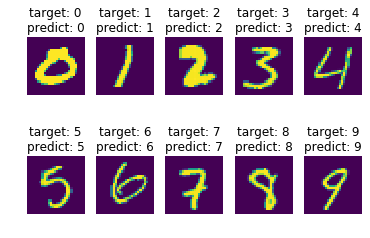

In [4]:
model_type = "cnn"
activation_type = "relu"
model = MNISTmodel(model_type, activation_type)
load_path = f"./trained/mnist/{model_type}-{activation_type}.pt"
model.load_state_dict(torch.load(load_path, map_location="cpu"))

def model_predict(model, samples, get_switches=False):
    model.eval()
    outputs = model(samples, store=True)
    preds = outputs.argmax(1)
    if get_switches:
        convs_outputs, switches = model.forward_switches(samples, store=True)
        return preds, convs_outputs, switches
    else:
        return preds

preds = model_predict(model, imgs)
fig, axes = plt.subplots(2, 5)

for ax, pred, img, label in zip(axes.flatten(), preds, imgs, labels):
    title = f"target: {label.item()}\npredict: {pred.item()}"
    ax.imshow(img.squeeze()*0.5+0.5)
    ax.set_title(title)
    ax.axis("off")
# plt.tight_layout()
plt.show()

In [5]:
def draw_actmap(tensor, title, labels=None, vis_row=2, vis_channel=4, dpi=80, return_fig=False):
    """
    vis_row: related with batch
    vis_channel: related with channel
    """
    tensor = tensor.detach()
    B, C, H, W = tensor.size()
    if C == 1:
        fig_h, fig_w = (4*B, 4)
        a, b = (1, 1)
    else:
        fig_h, fig_w = ((C//vis_channel)*(B//vis_row), vis_channel*(B//vis_row))
        a, b = (vis_channel, C//vis_channel)
    
    fig = plt.figure(figsize=(fig_h, fig_w), dpi=dpi)
    fig.suptitle(title, fontsize=20)
    o_grid = gridspec.GridSpec(vis_row, B//vis_row, wspace=0.1, hspace=0.2)
    for k, o_g in enumerate(o_grid):
        ax = fig.add_subplot(o_g)
        if labels is not None:
            t = f"target={labels[k]}"
            ax.set_title(t, fontsize=10)
        ax.axis("off")

        i_grid = gridspec.GridSpecFromSubplotSpec(a, b,
                subplot_spec=o_g, wspace=0.05, hspace=0.05)

        axes = []
        for i, img in enumerate(tensor[k]):
            ax = fig.add_subplot(i_grid[i])
            im = ax.imshow(img, cmap="coolwarm")
            ax.axis("off")
            axes += [ax]
        fig.colorbar(im, ax=axes, orientation='vertical')
    plt.show()
    if return_fig:
        return fig

## Activation Maps

In [6]:
model.activation_maps.keys()

odict_keys(['(1) Conv2d>relu', '(4) Conv2d>relu', '(8) Linear>relu'])

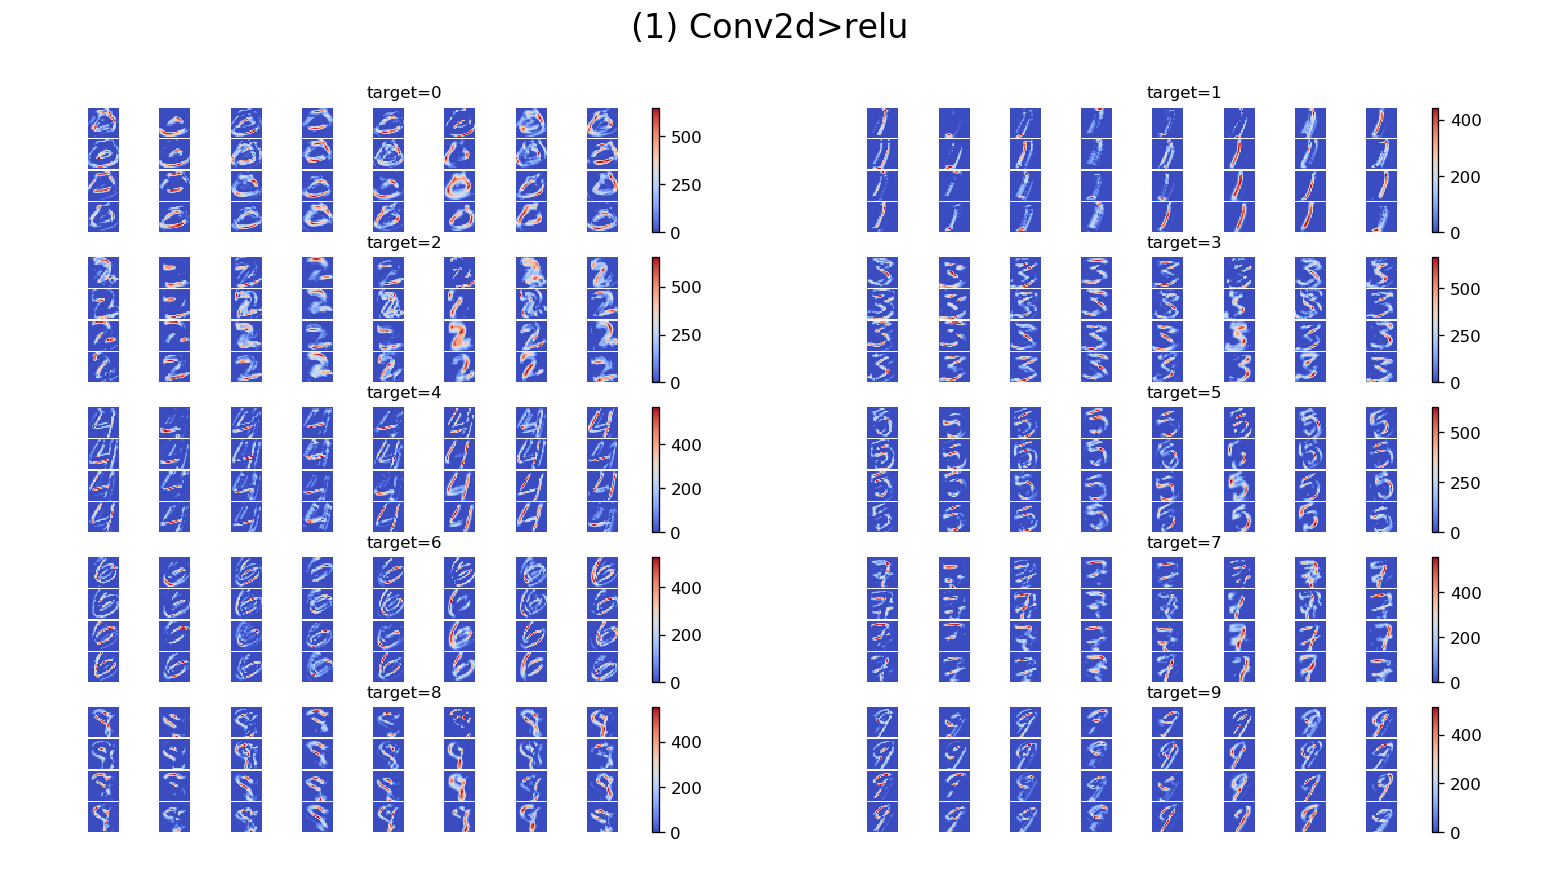

In [7]:
layer_name = "(1) Conv2d>relu"
act_map = model.activation_maps[layer_name]
draw_actmap(act_map, layer_name, labels=labels, vis_row=5, vis_channel=4, dpi=120)

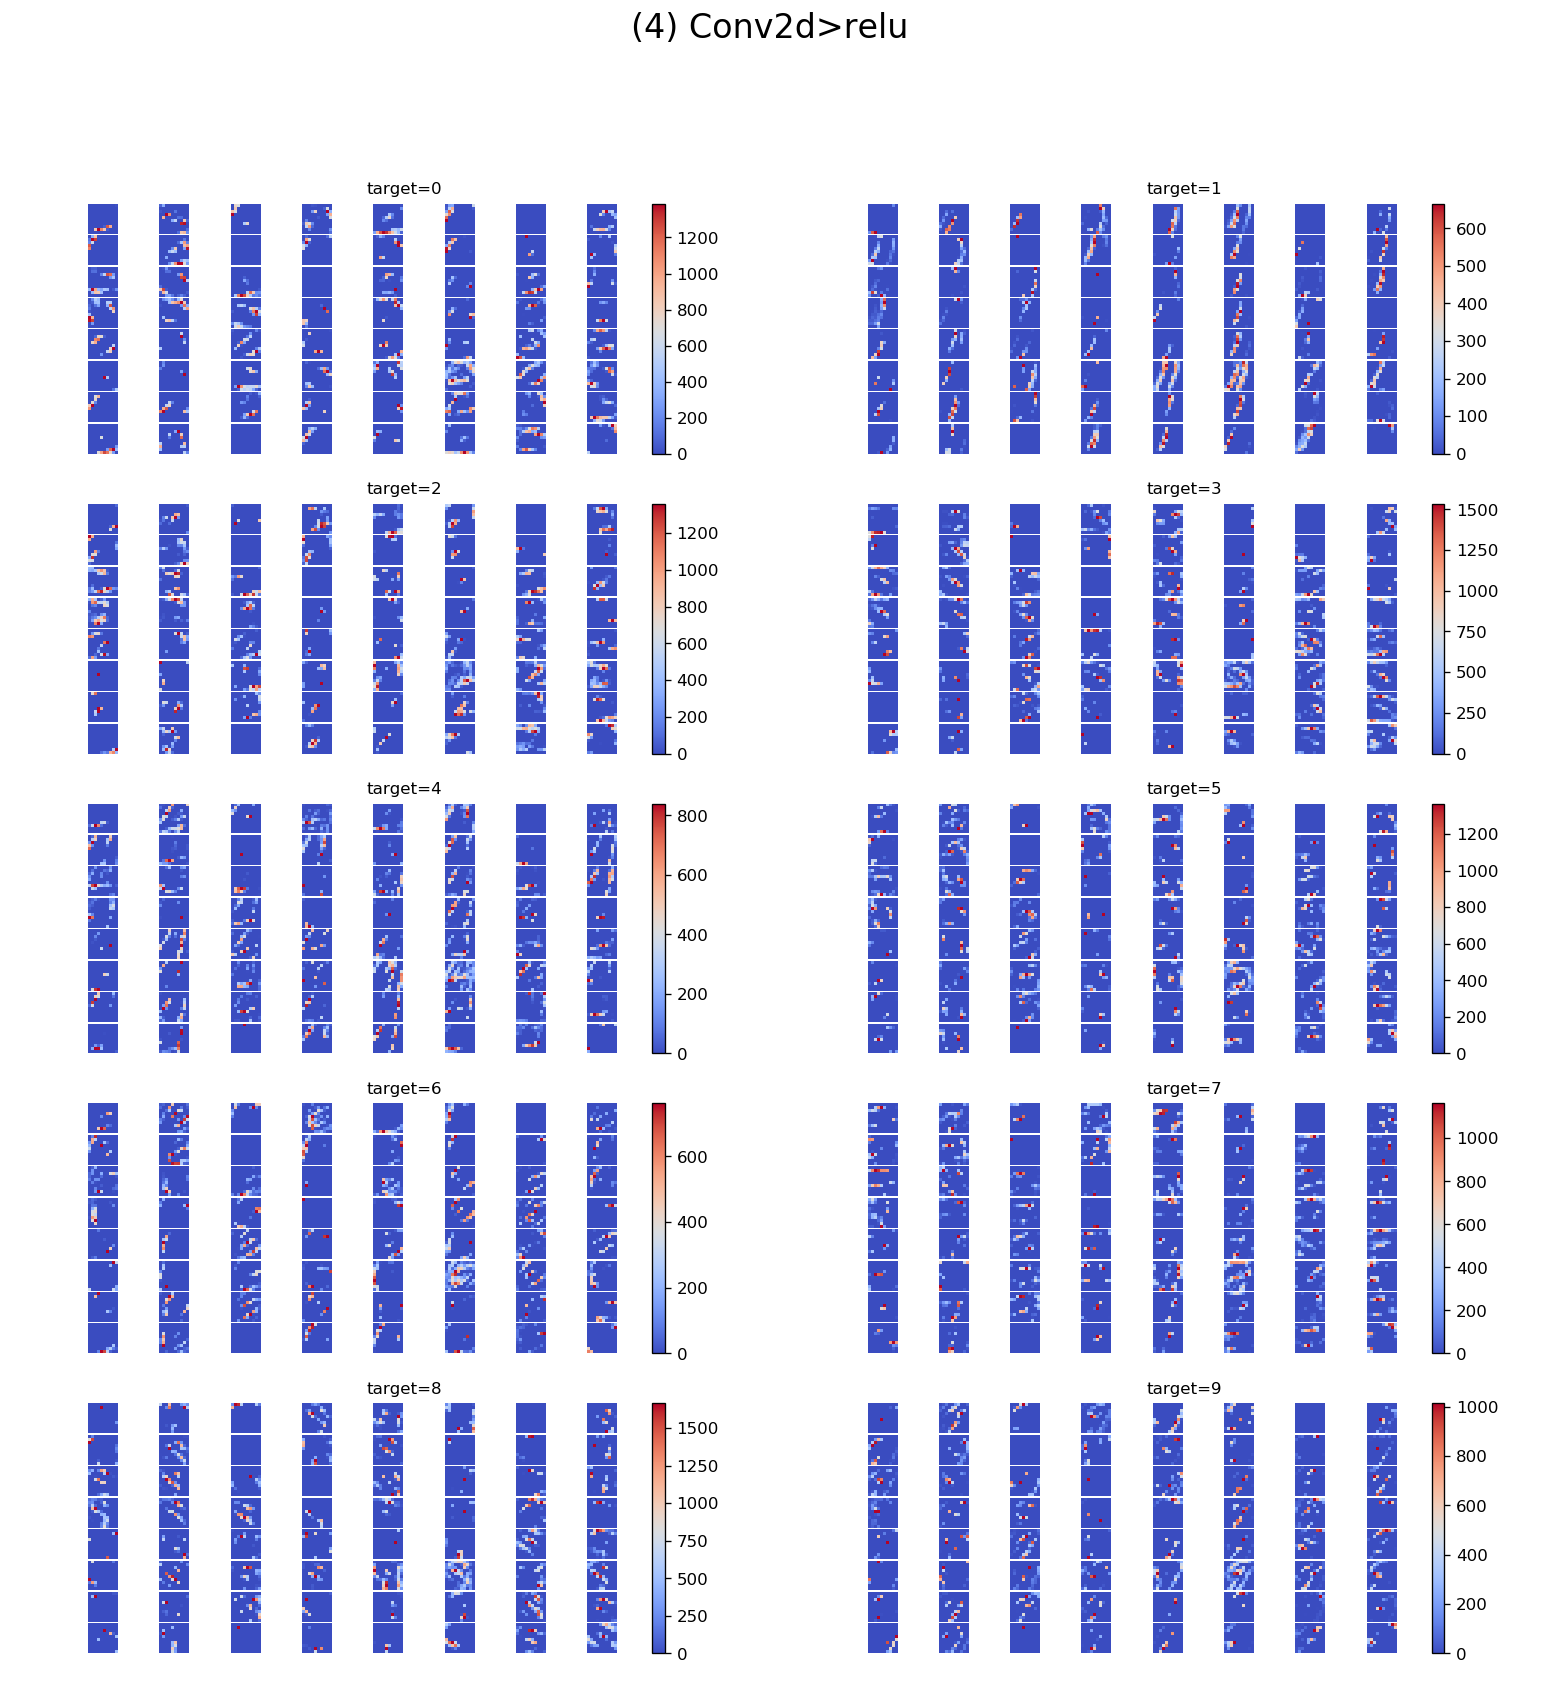

In [8]:
layer_name = "(4) Conv2d>relu"
act_map = model.activation_maps[layer_name]
draw_actmap(act_map, layer_name, labels=labels, vis_row=5, vis_channel=8, dpi=120)

## Deconvnet

`deconv_layer_num` is numbering from which deconv layers module(m =  "MaxPool > activation > Conv2d") numbering from the original cnn conv module(n = "Conv2d > activation > MaxPool")

for example:

```
deconv_layers = [m1, m2, m3, m4, m5]
if deconv_layer_num = 4, will goes from m4 to m5
* cnn_layer = [n5, n4, n3, n2, n1] (n.T = m, n5 is the first layer of cnn)
```

In [9]:
deconvnet.layers

Sequential(
  (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (1): ReLU()
  (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (4): ReLU()
  (5): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)

torch.Size([10, 64, 5, 5])


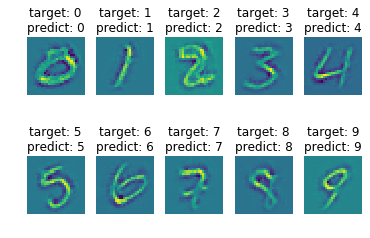

In [10]:
preds, _, switches = model_predict(model, imgs, get_switches=True)
deconvnet = deconvMNIST(model)

deconv_layer_num = 1
layer_name = f"({deconvnet.deconv_locs[deconv_layer_num]}) Conv2d>relu>MaxPool2d" 
convs = model.activation_maps[layer_name]
deconv_outputs = (deconvnet.deconv(convs, switches, deconv_layer_num, store=True).detach() - 0.5) / 0.5
print(convs.size())

fig, axes = plt.subplots(2, 5)

for ax, pred, img, label in zip(axes.flatten(), preds, deconv_outputs, labels):
    title = f"target: {label.item()}\npredict: {pred.item()}"
    ax.imshow(img.squeeze()*0.5+0.5)
    ax.set_title(title)
    ax.axis("off")
plt.show()

In [11]:
# deconv
vis_layers = deconvnet.activation_maps
vis_layers.keys()

odict_keys(['(2) ConvTranspose2d(in:64, out:32)', '(5) ConvTranspose2d(in:32, out:1)'])

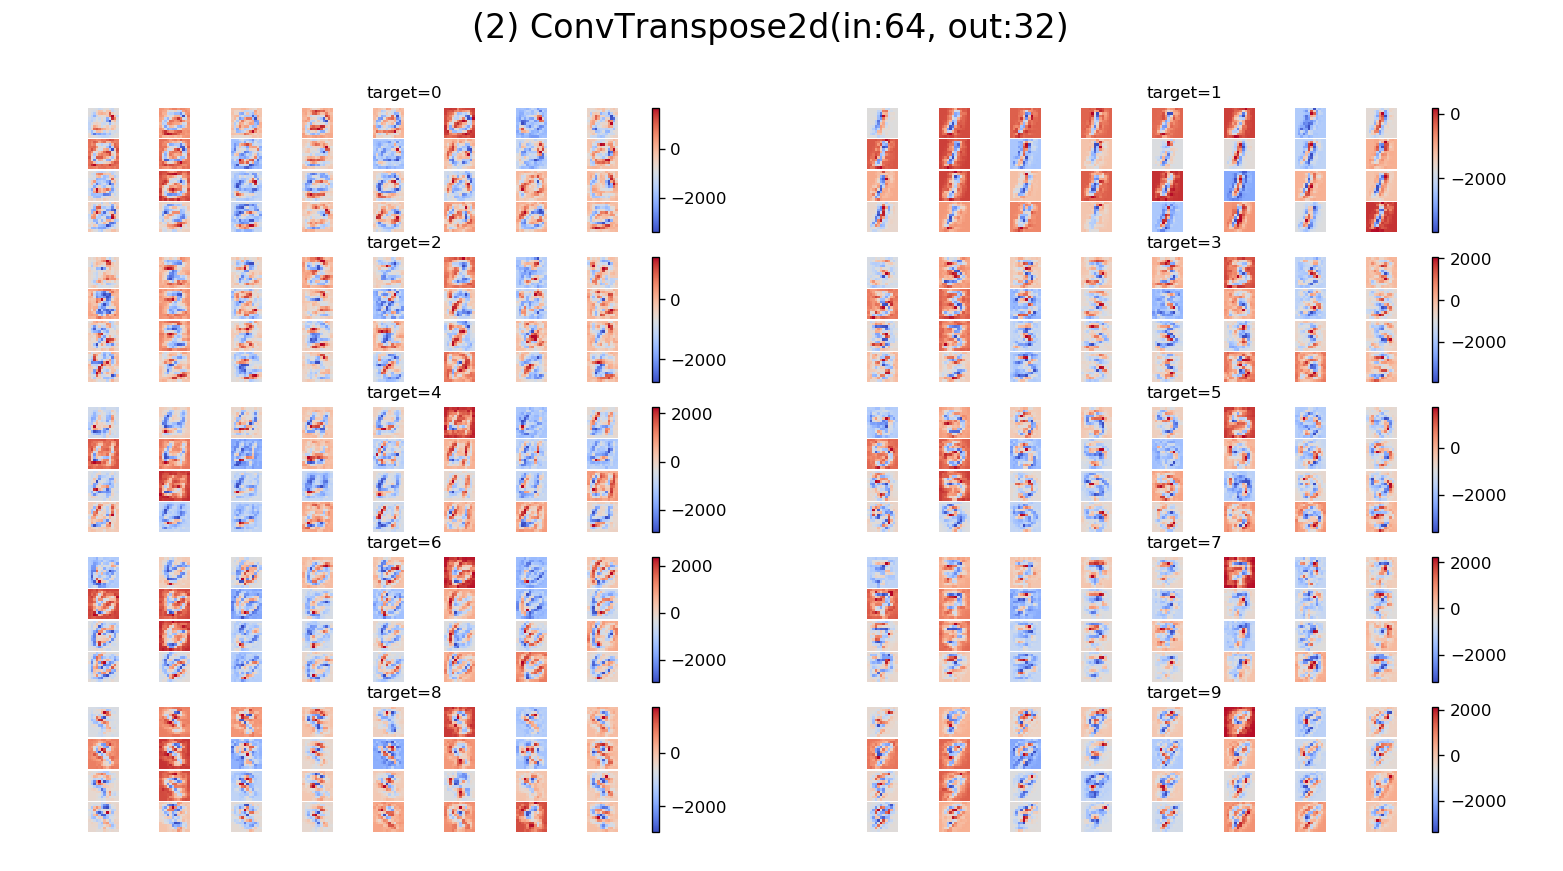

In [12]:
layer_name = "(2) ConvTranspose2d(in:64, out:32)"
draw_actmap(vis_layers[layer_name], layer_name, labels=labels, vis_row=5, vis_channel=4, dpi=120)

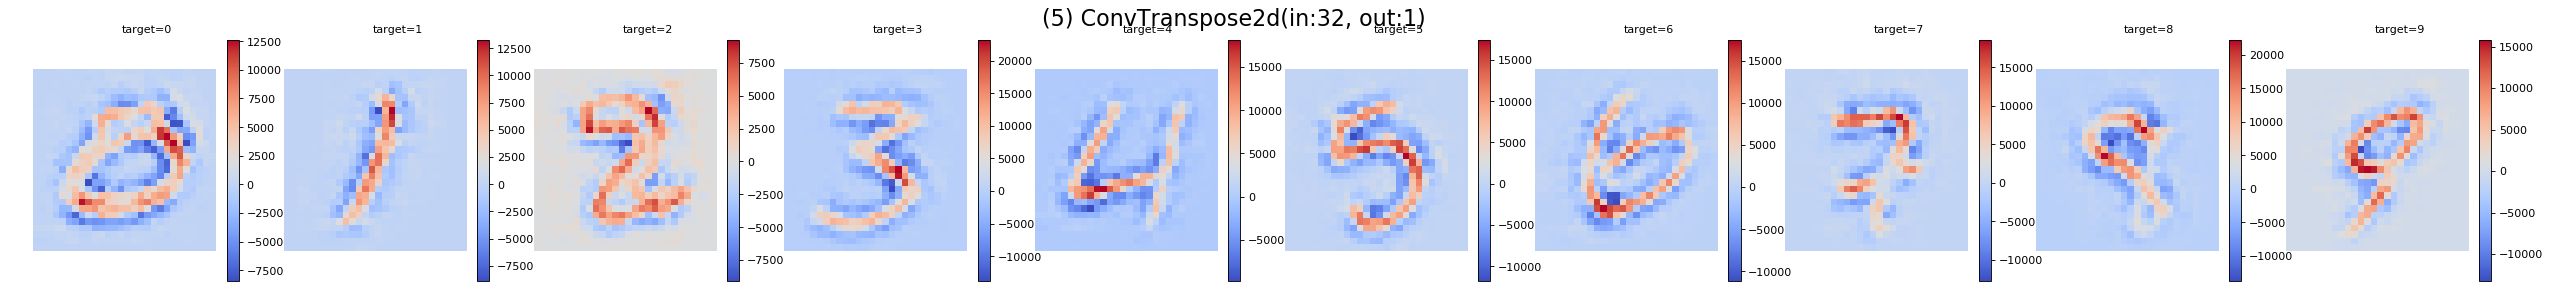

In [13]:
layer_name = "(5) ConvTranspose2d(in:32, out:1)"
draw_actmap(vis_layers[layer_name], layer_name, labels=labels, vis_row=1, vis_channel=1)

## LRP

In [40]:
def draw_attribution(tensor, title, labels=None, vis_row=2, dpi=80):
    tensor = tensor.detach()
    B, C, H, W = tensor.size()
    fig, axes = plt.subplots(vis_row, B//vis_row, figsize=((B//vis_row)*4, vis_row*4), dpi=dpi)
    fig.suptitle(title, fontsize=20, y=1.01)
    if B == 1:
        axes = [axes]
    for k, ax in enumerate(axes.flatten()):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(tensor[k].squeeze(), cmap="coolwarm")
        fig.colorbar(im, cax=cax, orientation='vertical')
        if labels is not None:
            t = f"target={labels[k]}"
        else:
            t = title
        ax.set_title(t, fontsize=16)
    plt.tight_layout()
    plt.show()

In [6]:
# lrp
lrp_model = lrpMNIST(model)
lrp_outputs = lrp_model.relprop(imgs, store=True, use_rho=True)

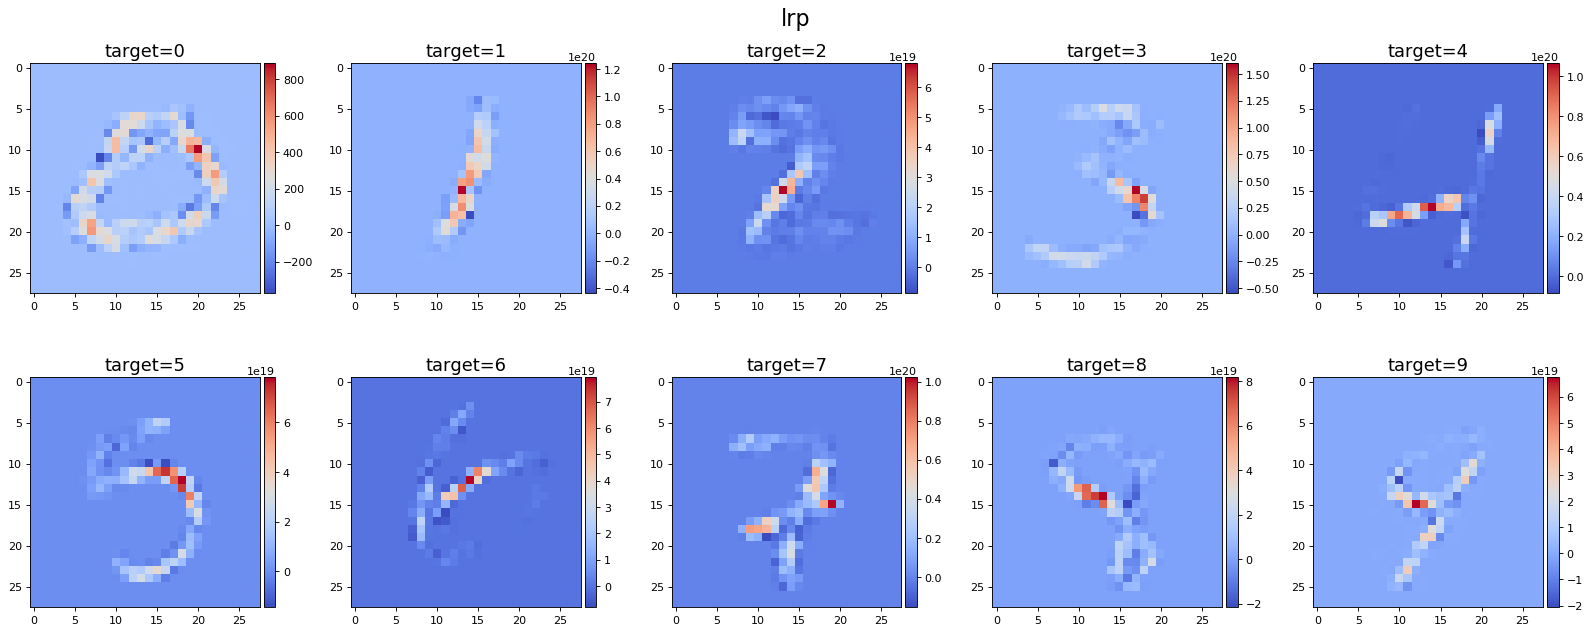

In [42]:
draw_attribution(lrp_outputs, "lrp", labels=labels, vis_row=2)

## Saliency

In [7]:
saliency_model = saliencyMNIST(model)
saliency_outputs = saliency_model.generate_saliency(imgs, labels)

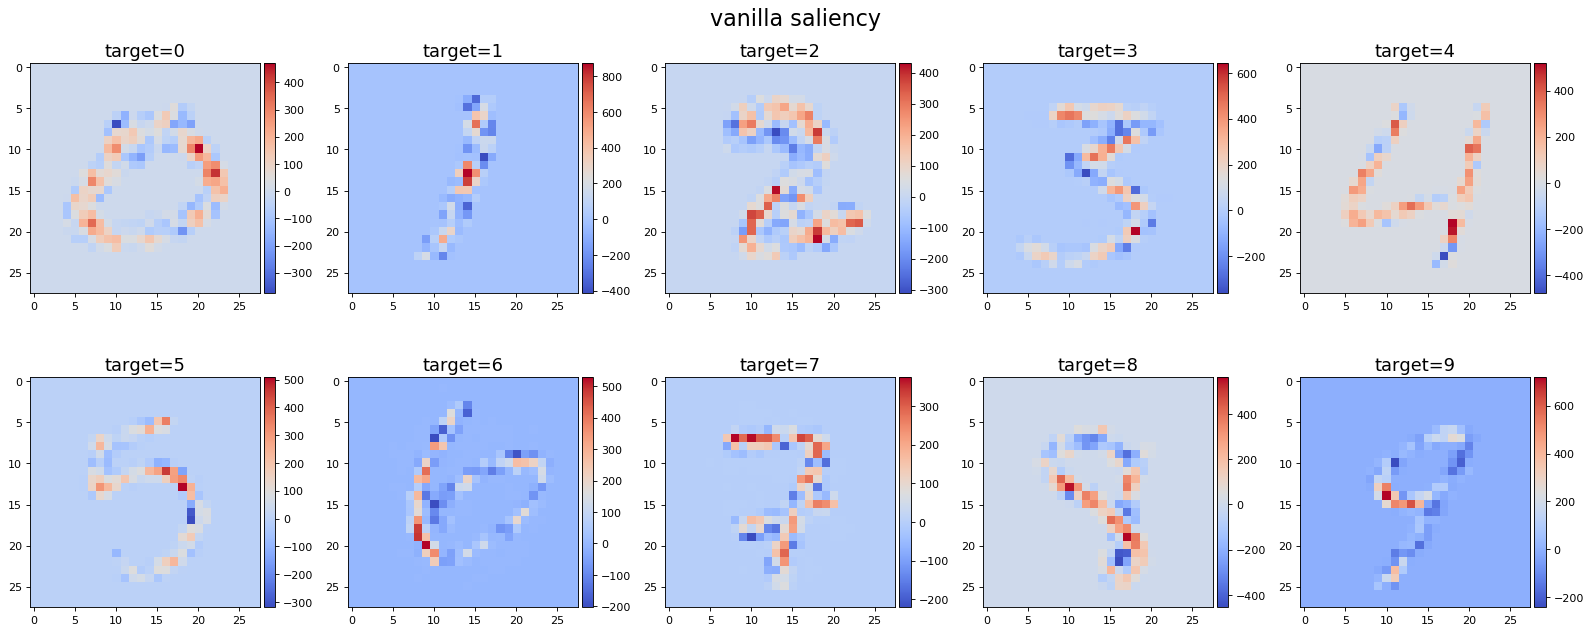

In [44]:
draw_attribution(saliency_outputs, "vanilla saliency", labels=labels, vis_row=2)

---

## ROAR

https://arxiv.org/abs/1806.10758

attribution method를 평가하기 위해 나온 Sensitivity 의 과정: 

1. attribution method 로 평가한다.
2. 최고 높은 attribution 픽셀을 지운다.
3. 다시 입력으로 해서 평가한다.

문제점: retrain 을 하지 않으면 해당 픽셀이 지워졌을 때, 지워진 픽셀 때문에 모델의 성능이 떨어진 것인지, 훈련된 모델이 해당 입력에 대해 최적화가 안되서 성능이 떨어진 것인지 판단이 안되기 때문?

What would happen without re-training? The re-training is the most computationally expensive aspect of ROAR. One should question whether it is actually needed. We argue that re-training is needed because machine learning models typically assume that the train and the test data comes from a similar distribution.
The replacement value c can only be considered uninformative if the model is trained to learn it as such. Without retraining, it is unclear whether degradation in performance is due to the introduction of artifacts outside of the original training distribution or because we actually removed information. This is made explicit in our experiment in Section 4.3.1, we show that without retraining the degradation is far higher than the modest decrease in performance observed with re-training. This suggests retraining has better controlled for artefacts introduced by the modification.


ROAR 의 프로세스:

1. 첫번째 모델을 훈련 시킨다.
2. attribution method 로 평가를 한다(accuracy 측정).
3. 입력에 대한 attribution을 랭킹으로 세고 10%, 30%, 70%, 90% 를 지운다.
4. 지운 데이터를 기반으로 다시 훈련시킨다(accuracy 측정).
5. 1~4 과정을 반복한다.

In [61]:
model_type = "cnn"
activation_type = "relu"
model = MNISTmodel(model_type, activation_type)
load_path = f"./trained/mnist/{model_type}-{activation_type}.pt"
model.load_state_dict(torch.load(load_path, map_location="cpu"))

<All keys matched successfully>

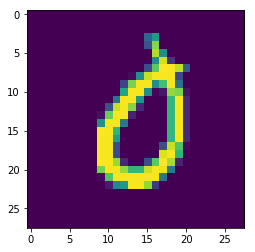

In [63]:
imgs, labels = get_samples(cat="all", sample_size=1)
B = imgs.size(0)
masks = torch.zeros(B, 1, 28, 28)
plt.imshow(imgs[0].squeeze())

In [73]:
attr_model = saliencyMNIST(model)

In [74]:
outputs = attr_model.get_attribution(imgs, labels)
_, indices = outputs.view(10, -1).sort(-1)

In [75]:
del_idx = int(0.1 * 28 * 28)
_, C, H, W = imgs.size()
masks = (masks+indices.le(del_idx).view(-1, C, H, W)).ge(1).byte()
deleted_imgs = (imgs * masks.eq(0))

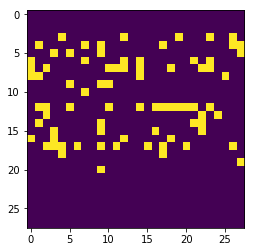

In [76]:
plt.imshow(masks[0].squeeze())

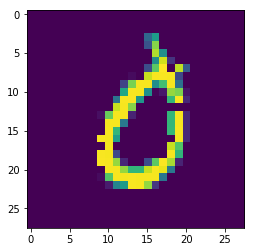

In [77]:
plt.imshow(deleted_imgs[0].squeeze())

In [79]:
outputs2 = attr_model.get_attribution(deleted_imgs, labels)
_, indices = outputs2.view(10, -1).sort(-1)

In [80]:
del_idx = int(0.2 * 28 * 28)
_, C, H, W = imgs.size()
masks = (masks+indices.le(del_idx).view(-1, C, H, W)).ge(1).byte()
deleted_imgs = (imgs * masks.eq(0))

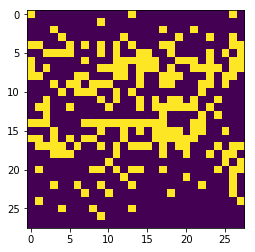

In [81]:
plt.imshow(masks[0].squeeze())

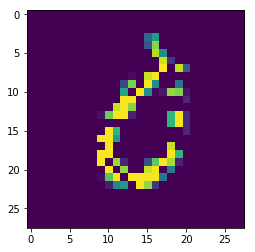

In [83]:
plt.imshow(deleted_imgs[0].squeeze())